# Setup

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

c=2.998e10
G=6.6743e-8
msun=1.989e33

# Define functions

### EOS

In [12]:
class eos_poly:
    def __init__(self,k,n):
        self.k = k
        self.n = n

    def rho(self, p):
        k = self.k
        n = self.n
        return np.sign(p)*np.abs(p/k)**(n/(n+1))
    
    def p(self, rho):
        k = self.k
        n = self.n
        return np.sign(rho)*k*np.abs(rho)**((n+1)/n)
    
    def ga(self, p):
        n = self.n
        return (n+1.)/n

### TOV equations solver

In [13]:
class solve_tov:
    def __init__(self,eos, eos_ga_p=None):
            self.eos = eos
            self.eos_ga_p = eos_ga_p
            self.r = np.array([])
            self.ysol = np.array([])
            self.p = np.array([])
            self.m = np.array([])
            self.nu = np.array([])
            self.rho = np.array([])
            self.ga = np.array([])

            self.atol = 0.
            self.rtol = 1.e-12

    def deriv(self,r,y):
        if self.eos == None:
            exit('solve_tov: self.eos_rho not provided')
        p=y[0]
        m=y[1]
        nu=y[2]
        rho = self.eos.rho(p)
        
        dydr=0.0*y
        dydr[0]= -G*(rho+p/c**2)*(m+4*np.pi*r**3*p/c**2)/r**2/(1-2*G*m/r/c**2)
        dydr[1]= 4*np.pi*r**2*rho
        dydr[2]= 2*G/c**2*(m+4*np.pi*r**3*p/c**2)/r**2/(1-2*G*m/r/c**2)
        return dydr

    def ivp(self, p0, pcut):
        rho0 = self.eos.rho(p0)
        Rs = np.sqrt(3.*p0/(2.*np.pi*G*(rho0+p0/c**2)*(rho0+3.*p0/c**2)))
        dr = 1e-5*Rs
        r0 = dr
        m0 = 4.*np.pi/3*rho0*r0**3
        nu0 = 2.*np.pi/3*G/c**2*(rho0+3.*p0/c**2)*r0**2

        y = np.zeros(3)
        y[0] = p0
        y[1] = m0
        y[2] = nu0

        def pcut_event(r,y):
            return y[0]-pcut
        pcut_event.terminal = True
        pcut_event.direction = -1
        
        isol = solve_ivp(self.deriv, t_span=[r0,Rs*30], y0 = y \
                        , atol = self.atol, rtol = self.rtol, events = pcut_event)
        self.r = isol.t
        self.ysol = isol.y

        self.get_sol()

    def find_yr(self,r):
        idx = (np.abs(self.r - r)).argmin()
        isol = solve_ivp(self.deriv, t_span=[self.r[idx],r], y0 = np.array([self.p[idx], self.m[idx], self.nu[idx]]) \
                        , atol = self.atol, rtol = self.rtol)

        self.pf, self.mf, self.nuf = isol.y[0,-1], isol.y[1,-1], isol.y[2,-1]
        self.rhof = self.eos.rho(self.pf)

        if self.eos_ga_p == None:
            self.gaf = self.eos.ga(self.pf)
            self.schf = 0.
        else:
            self.gaf = self.eos_ga_p(self.pf)
            self.schf = self.get_sch(r,self.pf,self.mf,self.nuf)

    def get_sol(self):
        self.p = self.ysol[0,:]
        self.m = self.ysol[1,:]
        self.nu = self.ysol[2,:]

        nu_R=np.log(1.-2.*G/c**2*self.m[-1]/self.r[-1])-self.nu[-1]
        self.nu=self.nu+nu_R

        self.rho = np.array(list(map(self.eos.rho, self.p)))
        
        if self.eos_ga_p == None:
            self.ga = np.array(list(map(self.eos.ga, self.p)))
            self.sch = 0.0*self.r
        else:
            self.ga = np.array(list(map(self.eos_ga_p, self.p)))
            self.sch = np.array(list(map(self.get_sch, self.r, self.p, self.m, self.nu)))
        
    def get_sch(self,r,p,m,nu):
        ga0 = self.eos.ga(p)
        if self.eos_ga_p == None:
            return 0.0
        else:
            ga = self.eos_ga_p(p)
            dpdr, _ , _ = self.deriv(r,np.array([p,m,nu]))
            return (1./ga0-1./ga)/p*dpdr

### Hartle's formalism solver

In [14]:
class bvp_rot:
    def __init__(self,bsol):
        self.bsol = bsol
        self.atol_factor = 1.e-8
        self.rtol = 1.e-8
        self.ode_method = 'RK45'

    '''Define ODE'''
    '''w is -bar{omega} in Hartle 1967'''
    def deriv(self,r,y):
        w=y[0]
        dw=y[1]
        h2_p=y[2]
        u2_p=y[3]
        h2_h=y[4]
        u2_h=y[5]

        self.bsol.find_yr(r)
        p, m, nu = G/c**4*self.bsol.pf, G/c**2*self.bsol.mf, self.bsol.nuf
        rho = G/c**2*self.bsol.rhof
        
        elam = 1./(1-2*m/r)
        enu = np.exp(nu)
        dnu = 2*(m+4*np.pi*r**3*p)/r**2*elam
        jj = 1./np.sqrt(elam*enu)
        jjp=-jj*np.pi*8*r*(rho+p)*elam

        dydr = np.empty_like(y)
        '''Hartle 1967 Eq. (43)'''
        dydr[0] = dw
        dydr[1] = np.pi*16*(rho+p)*elam*w - (4./r - np.pi*4*r*(rho+p)*elam )*dw
        '''Hartle 1967 Eqs. (125) & (126)'''
        dydr[2] = -4./r**2*elam/dnu*u2_p + (-dnu + elam/dnu*(np.pi*8*(rho+p)-4*m/r**3))*h2_p \
                + r**3/6*(r*dnu/2-elam/r/dnu)*jj*dw**2 - r**2/3*(r*dnu/2+ elam/r/dnu)*jjp*w**2
        dydr[3] = -dnu*h2_p +(1./r+dnu/2)*(-r**3/3*jjp*w**2+jj/3*r**4*dw**2)
        dydr[4] = -4./r**2*elam/dnu*u2_h + (-dnu + elam/dnu*(np.pi*8*(rho+p)-4*m/r**3))*h2_h
        dydr[5] = -dnu*h2_h
        return dydr

    '''Regular condition at stellar center'''
    def r0_reg(self,r):
        bsol = self.bsol

        bsol.find_yr(r)
        p, m, nu = G/c**4*bsol.pf, G/c**2*bsol.mf, bsol.nuf
        rho = G/c**2*bsol.rhof

        y0 = np.zeros(6)
        y0[0]= 1. + 8./5*np.pi*(rho+p)*r**2
        y0[1]= 16./5*np.pi*(rho+p)*r**2
        y0[2]= r**2
        y0[3]= (-np.pi*2*(rho/3+p) -np.pi*4/3*(rho+p)/np.exp(nu)*y0[0]**2)*r**4
        y0[4]= r**2
        y0[5]= -np.pi*2*(rho/3+p)*r**4
        return y0
    
    '''Integrate ODE'''
    def integrate(self):

        bsol = self.bsol

        r0 = bsol.r[0]
        rf = bsol.r[-1]
        first_step = np.abs(rf-r0)/400

        y0 = self.r0_reg(r0)
        
        yscale = y0*0.
        yscale[0] = 1.
        yscale[1] = 1./bsol.r[-1]
        yscale[2:6] = 1.
        atol = yscale*self.atol_factor

        isol = solve_ivp(self.deriv, t_span=[r0,rf], first_step = first_step, \
                        method = self.ode_method , y0 = y0, atol = atol, rtol = self.rtol)
        self.r = isol.t
        self.w  = isol.y[0,:]
        self.dw  = isol.y[1,:]
        self.h2_p  = isol.y[2,:]
        self.u2_p  = isol.y[3,:]
        self.h2_h  = isol.y[4,:]
        self.u2_h  = isol.y[5,:]
        return

    '''Match with exterior solution to find I and Q'''
    def solve_IQ(self):
        '''Solve the differential equations to get w, dw, h2_p, u2_p, h2_h, u2_h'''
        self.integrate()

        r = self.bsol.r[-1]
        m = G/c**2*self.bsol.m[-1]
        w = self.w[-1]
        dw = self.dw[-1]
        h2_p = self.h2_p[-1]
        u2_p = self.u2_p[-1]
        h2_h = self.h2_h[-1]
        u2_h = self.u2_h[-1]

        '''Moment of inertia: Eq. (47) of Hartle 1967'''
        moi= r**4/(6*w/dw+2*r)

        '''Quadrupole moment: Hartle 1967 Eqs. (139) & (140)'''
        '''JJ is the spin^2 defined in Eq. (47) of Hartle.
            We take a derivative in r so we don't have to solve for Omega_s.
        '''
        z=r/m-1
        JJ=(r**4/6*dw)**2
        Q21=np.sqrt(z**2-1)*((3*z**2-2)/(z**2-1) - 1.5*z*np.log((z+1)/(z-1)) )
        Q22=1.5*(z**2-1)*np.log((z+1)/(z-1)) - (3*z**3-5*z)/(z**2-1)
        '''Matrix problem structure: 
                [a00, a01][A]   [p1]
                [a10, a11][B] = [p2]
        '''
        a00, a01 = Q22, -h2_h
        a10, a11 = 2*m/r/np.sqrt(1-2*m/r)*Q21, -u2_h
        p1 = h2_p - JJ*(1./m/r**3 + 1./r**4)
        p2 = u2_p + JJ/r**4
        A = (a11*p1 - a01*p2)/(a00*a11-a01*a10)
        '''Solving with numpy (removed)'''
        # mat = np.array([[a00,a01],[a10,a11]])
        # vec = np.array([p1,p2])
        # A = np.linalg.solve(mat,vec)[0]
        
        
        '''Determine Q: Eq. (138) of Hartle 1967
            ,but fixed a typo of (16/5 -> 8/5) according to Hartle 1968
            ,and changed a minus sign following Yagi and Yunes 2013. (See references below)
        '''
        Q = -(1./m + 8*A/JJ*m**3/5)
        '''Note: Q = Q_raw/(I Omega_s)^2, where Q_raw is defined by 
            Q_{ij} = Q_raw (n_i n_j - 1/3 delta_{ij})
        '''
        return moi/(G/c**2), Q/(G/c**2)

    '''
    References
        Hartle 1967:
        https://ui.adsabs.harvard.edu/abs/1967ApJ...150.1005H/abstract
        Hartle 1968:
        https://ui.adsabs.harvard.edu/abs/1968ApJ...153..807H/abstract
        Yagi and Yunes 2013:
        https://journals.aps.org/prd/abstract/10.1103/PhysRevD.88.023009
    '''

### Love number solver

In [15]:
class bvp_love:
    def __init__(self,bsol):
        self.bsol = bsol
        self.atol_factor = 1.e-6
        self.rtol = 1.e-8
        self.ode_method = 'RK45'

    '''Define ODE'''
    def deriv(self,r,y):
        self.bsol.find_yr(r)
        p, m, nu = G/c**4*self.bsol.pf, G/c**2*self.bsol.mf, self.bsol.nuf
        rho, ga = G/c**2*self.bsol.rhof, self.bsol.gaf

        ell = 2.
        elam = 1./(1-2*m/r)
        cs2 = ga*p/(rho+p)
        dnu = 2*(m+4*np.pi*r**3*p)/r**2*elam
        Q = np.pi*4*elam*(5.*rho+9.*p+(rho+p)/cs2)-ell*(ell+1)*elam/r**2-dnu**2
        '''Eq. (4.7) of Chan 2015'''
        dydr = np.empty_like(y)
        dydr[0]=-(y[0]**2+y[0]*elam*(1 + np.pi*4*r**2*(p-rho))+r**2*Q)/r

        return dydr
    
    '''Integrate ODE'''
    def integrate(self):

        bsol = self.bsol

        r0 = bsol.r[0]
        rf = bsol.r[-1]
        first_step = np.abs(rf-r0)/400

        y0 = np.array([2.])
        
        atol = np.ones(1)*self.atol_factor

        isol = solve_ivp(self.deriv, t_span=[r0,rf], first_step = first_step, \
                        method = self.ode_method, y0 = y0, atol = atol, rtol = self.rtol)
        self.r = isol.t
        self.y  = isol.y[0,:]

    '''Match with exterior solution to find k2'''
    def solve_Love(self):
        '''Solve the differential equations to get y'''
        self.integrate()

        r = self.bsol.r[-1]
        m = G/c**2*self.bsol.m[-1]
        rho = G/c**2*self.bsol.rho[-1]

        '''Junction condition for the possible surface density jump. Eq. (4.6) of Chan 2015'''
        y = self.y[-1] - np.pi*4*r**3/m*rho

        Co = m/r
        if (Co>3.e-3):
            '''Eq. (23) of Hinderer 2008. 
                Eq. (4.5) of Chan 2015 is the same equation but contains 2 typos
            '''
            t1 = 8./5*Co**5*(1-2*Co)**2*(2*Co*(y-1)+2-y)
            t2 = 2*Co*(4*(y+1)*Co**4+(6*y-4)*Co**3+(26-22*y)*Co**2 \
                +3*Co*(5*y-8)-3*y+6)
            t3 = 3*(1-2*Co)**2*(2*Co*(y-1)-y+2)*np.log(1-2*Co)
            k2 = t1/(t2+t3)
        else:
            '''Eq. (6.25) of Chan 2016'''
            t1 = (2 - y)/2/(y + 3)
            t2 = 5*Co*(y**2 + 2*y - 6)/2/(y + 3)**2
            t3 = 5*Co**2 * (11*y**3 + 66*y**2 + 52*y - 204)/14/(y + 3)**3
            k2 = t1 + t2 + t3
        
        return k2


    '''
    References
        Hinderer 2008:
        https://iopscience.iop.org/article/10.1086/533487
        Chan 2015:
        https://journals.aps.org/prd/abstract/10.1103/PhysRevD.91.044017
        Chan 2016:
        https://journals.aps.org/prd/abstract/10.1103/PhysRevD.93.024033
    '''

### Universal relations from Yagi and Yunes 2017

In [16]:
'''Table 1 of Yagi & Yunes 2017'''
moi_love = lambda x: np.exp(1.496 + 0.05951*np.log(x) + 0.02238*np.log(x)**2 - 6.953e-4*np.log(x)**3 + 8.345e-6*np.log(x)**4)
moi_Q = lambda x: np.exp(1.393 + 0.5471*np.log(x) + 0.03028*np.log(x)**2 + 0.01926*np.log(x)**3 + 4.434e-4*np.log(x)**4)
Q_love = lambda x: np.exp(0.1940 + 0.09163*np.log(x) + 0.04812*np.log(x)**2 - 4.283e-3*np.log(x)**3 + 1.245e-4*np.log(x)**4)


'''
References
    Yagi & Yunes 2017:
    https://linkinghub.elsevier.com/retrieve/pii/S0370157317300492
'''

'\nReferences\n    Yagi & Yunes 2017:\n    https://linkinghub.elsevier.com/retrieve/pii/S0370157317300492\n'

# Computations

## Parameters

In [17]:
rho_list = np.logspace(14.5,16.,14)
pcut = 1.e20

## Compute background solution and then $k_2$, $I$ and $Q$

In [18]:
eos = eos_poly(k = 1.e35/(1.e15)**2, n = 1.)

tov=solve_tov(eos)

m_list = np.empty_like(rho_list)
r_list = np.empty_like(rho_list)
moi_list = np.empty_like(rho_list)
love_list = np.empty_like(rho_list)
Q_list = np.empty_like(rho_list)

for idx, rho in enumerate(rho_list):
    '''Compute background'''
    tov.ivp(p0= eos.p(rho),pcut=pcut)
    m_list[idx] = tov.m[-1]
    r_list[idx] = tov.r[-1]
    '''Compute k2, and then rescaled Love'''
    cal_love = bvp_love(bsol = tov)
    k2 = cal_love.solve_Love()
    love_list[idx] = k2*2./3/(G*m_list[idx]/r_list[idx]/c**2)**5
    '''Compute I, Q, and then the rescaled I, Q'''
    cal_IQ = bvp_rot(bsol = tov)
    moi, Q = cal_IQ.solve_IQ()
    moi_list[idx] = G/c**2*moi/(G*m_list[idx]/c**2)**3
    Q_list[idx] = G/c**2*Q*(G*m_list[idx]/c**2)

### Plots

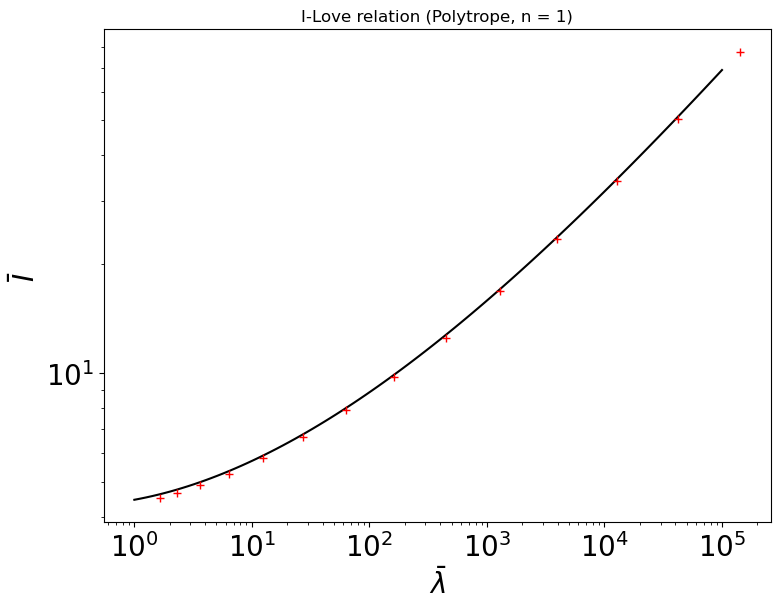

In [19]:
love_fit_list = np.logspace(0.,5.,100)

plt.figure(figsize=(8.6,6.4), dpi= 100)
plt.plot(love_fit_list, moi_love(love_fit_list), 'k-')
plt.plot(love_list, moi_list, linestyle = '', marker = '+', color = 'red')
plt.title(r'I-Love relation (Polytrope, n = 1)')
plt.xlabel(r'$\bar{\lambda}$',fontsize=20)
plt.ylabel(r'$\bar{I}$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.close()

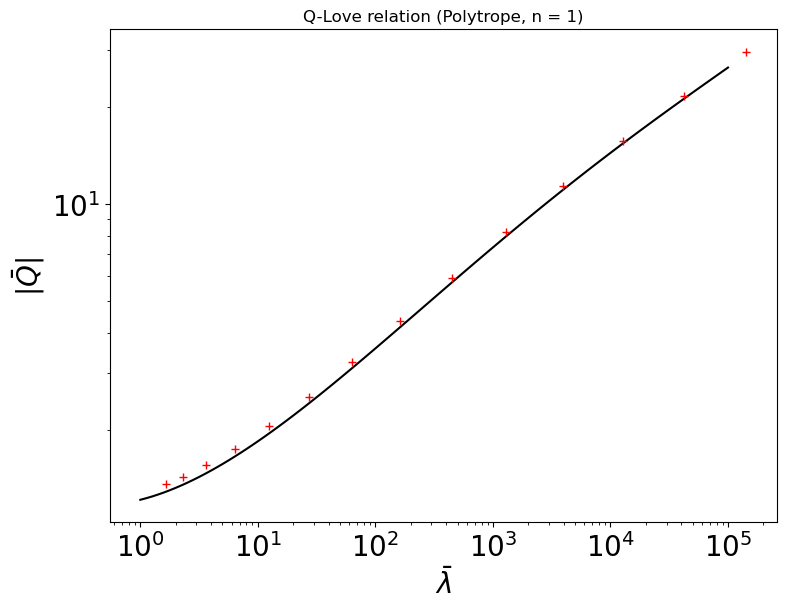

In [20]:
plt.figure(figsize=(8.6,6.4), dpi= 100)
plt.plot(love_fit_list, Q_love(love_fit_list), 'k-')
plt.plot(love_list, np.abs(Q_list), linestyle = '', marker = '+', color = 'red')
plt.title(r'Q-Love relation (Polytrope, n = 1)')
plt.xlabel(r'$\bar{\lambda}$',fontsize=20)
plt.ylabel(r'$|\bar{Q}|$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.close()